In [1]:
import numpy as np
from qiskit import *

In [14]:
from qiskit.circuit import Gate

my_gate = Gate(name ='my_gate', num_qubits=2,params=[])

In [15]:
qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.append(my_gate, [qr[0], qr[1]])
circ.append(my_gate, [qr[1], qr[2]])

circ.draw()

┌──────────┐            
q_0: ┤0         ├────────────
     │  my_gate │┌──────────┐
q_1: ┤1         ├┤0         ├
     └──────────┘│  my_gate │
q_2: ────────────┤1         ├
                 └──────────┘

In [17]:
#sub-circuitの作成
sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circ')
sub_circ.h(sub_q[0])
sub_circ.crz(1, sub_q[0], sub_q[1])
sub_circ.barrier()
sub_circ.id(sub_q[1])
sub_circ.u(1,2, -2, sub_q[0])

#ゲートに変換して、好きな大きな回路の場所にはりつけ
sub_inst = sub_circ.to_instruction()

qc = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.cx(qc[1], qc[2])
circ.append(sub_inst, [qr[1], qr[2]])

circ.draw()


┌───┐                       
q_0: ┤ H ├──■────────────────────
     └───┘┌─┴─┐     ┌───────────┐
q_1: ─────┤ X ├──■──┤0          ├
          └───┘┌─┴─┐│  sub_circ │
q_2: ──────────┤ X ├┤1          ├
               └───┘└───────────┘

In [18]:
#サブ回路は decompose メソッドで分解
decomposed_circ = circ.decompose()
decomposed_circ.draw()

┌─────────┐                                        
q_0: ┤ U2(0,π) ├──■─────────────────────────────────────
     └─────────┘┌─┴─┐     ┌───┐          ░ ┌───────────┐
q_1: ───────────┤ X ├──■──┤ H ├────■─────░─┤ U(1,2,-2) ├
                └───┘┌─┴─┐└───┘┌───┴───┐ ░ └───┬───┬───┘
q_2: ────────────────┤ X ├─────┤ Rz(1) ├─░─────┤ I ├────
                     └───┘     └───────┘ ░     └───┘

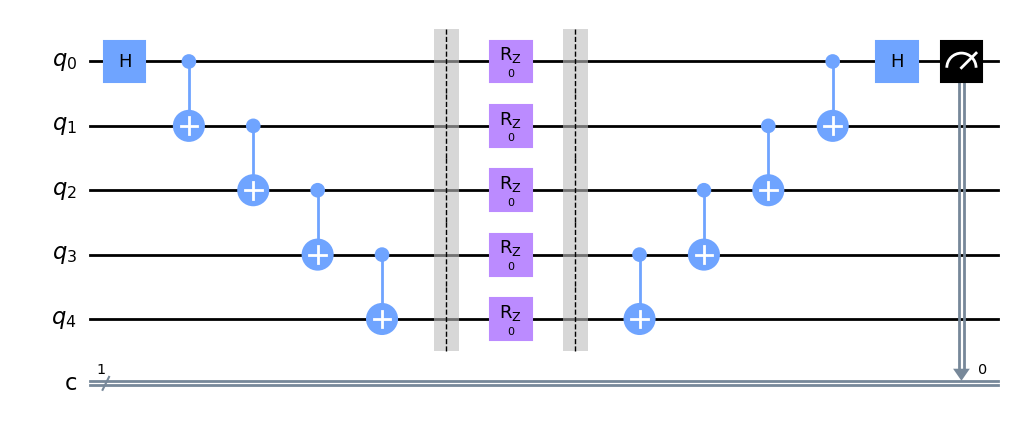

In [19]:
#パラメータ化された回路
from qiskit.circuit import Parameter

theta = Parameter('0')

n= 5
qc = QuantumCircuit(5,1)
qc.h(0)
for i in range(n-1):
    qc.cx(i, i+1)

qc.barrier()
qc.rz(theta, range(5))
qc.barrier()

for i in reversed(range(n-1)):
    qc.cx(i, i+1)
qc.h(0)
qc.measure(0,0)

qc.draw('mpl')

In [21]:
print(qc.parameters)

ParameterView([Parameter(0)])


In [28]:
#parametersを値にバインド

theta_range = np.linspace(0, 2 * np.pi, 128)

circuits = [qc.bind_parameters({theta: theta_val})
           for theta_val in theta_range]
circuits[-1].draw()

┌───┐                     ░ ┌────────┐ ░                     ┌───┐┌─┐
q_0: ┤ H ├──■──────────────────░─┤ Rz(2π) ├─░──────────────────■──┤ H ├┤M├
     └───┘┌─┴─┐                ░ ├────────┤ ░                ┌─┴─┐└───┘└╥┘
q_1: ─────┤ X ├──■─────────────░─┤ Rz(2π) ├─░─────────────■──┤ X ├──────╫─
          └───┘┌─┴─┐           ░ ├────────┤ ░           ┌─┴─┐└───┘      ║ 
q_2: ──────────┤ X ├──■────────░─┤ Rz(2π) ├─░────────■──┤ X ├───────────╫─
               └───┘┌─┴─┐      ░ ├────────┤ ░      ┌─┴─┐└───┘           ║ 
q_3: ───────────────┤ X ├──■───░─┤ Rz(2π) ├─░───■──┤ X ├────────────────╫─
                    └───┘┌─┴─┐ ░ ├────────┤ ░ ┌─┴─┐└───┘                ║ 
q_4: ────────────────────┤ X ├─░─┤ Rz(2π) ├─░─┤ X ├─────────────────────╫─
                         └───┘ ░ └────────┘ ░ └───┘                     ║ 
c: 1/═══════════════════════════════════════════════════════════════════╩═
                                                                        0

In [29]:
backend =BasicAer.get_backend('qasm_simulator')
job = backend.run(transpile(circuits, backend))
counts =job.result().get_counts()

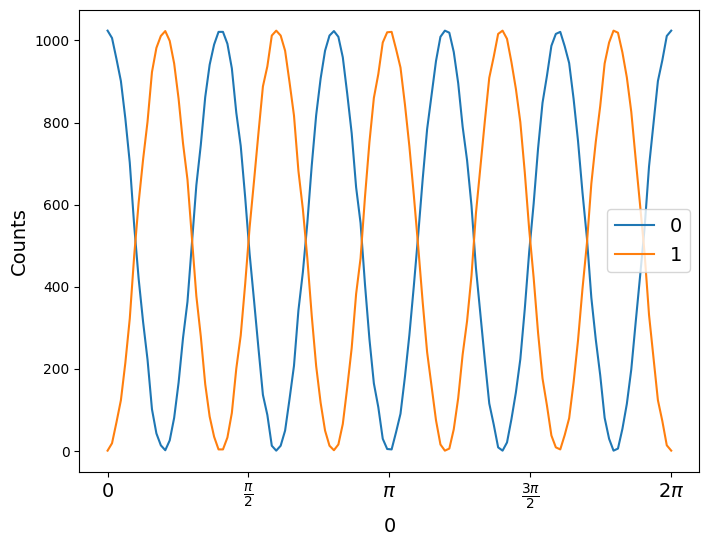

In [30]:
#5つのqubitエンタングルメントに対してRz（０）グローバル回転を適用し量子ビット0で期待

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ax =fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('0',0),counts)), '-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1',0),counts)), '-', label='1')

ax.set_xticks([i * np.pi / 2 for i in range(5) ])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('0', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)

In [34]:
import time 
from itertools import combinations
from qiskit.compiler import assemble
from qiskit.test.mock import FakeVigo

start = time.time()
qcs = []

theta_range = np.linspace(0, 2*np.pi, 32)

for n in theta_range:
    qc = QuantumCircuit(5)

    for k in range(8):
        for i,j in combinations(range(5), 2):
            qc.cx(i,j)
        qc.rz(n, range(5))
        for i,j in combinations(range(5), 2):
            qc.cx(i,j)


    qcs.append(qc)

compiled_circuits = transpile(qcs, backend=FakeVigo())
qobi = assemble(compiled_circuits, backend=FakeVigo())

end = time.time()
print ('拘束された回路の集合をコンパイルする時間: ',end-start) 

C:\Users\desha\AppData\Local\Temp\ipykernel_5600\4189480483.py:4: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeVigo


Time compiling over set of bound circuits: 1.4533581733703613


In [36]:
start = time.time()
qc = QuantumCircuit(5)
theta = Parameter('theta')

for k in range(8):
    for i,j in combinations(range(5), 2):
        qc.cx(i,j)
    qc.rz(theta, range(5))
    for i,j in combinations(range(5), 2):
        qc.cx(i,j)

transpiled_qc = transpile(qc, backend=FakeVigo())
qobj = assemble([transpiled_qc.bind_parameters({theta: n})
                 for n in theta_range], backend=FakeVigo())
end = time.time()
print('パラメータ化された回路をコンパイルし、バインド： ', end-start)

パラメータ化された回路をコンパイルし、バインド：  0.4144439697265625


In [38]:
#コンポジション
phi = Parameter('phi')

sub_circ1 = QuantumCircuit(2, name='sc_1')
sub_circ1.rz(phi, 0)
sub_circ1.rx(phi, 1)

sub_circ2 = QuantumCircuit(2, name='sc_2')
sub_circ2.rx(phi, 0)
sub_circ2.rz(phi, 1)

qc = QuantumCircuit(4)
qr = qc.qregs[0]

qc.append(sub_circ1.to_instruction(), [qr[0], qr[1]])
qc.append(sub_circ2.to_instruction(), [qr[0], qr[1]])

qc.append(sub_circ2.to_instruction(), [qr[2], qr[3]])

print(qc.draw())

     ┌────────────┐┌────────────┐
q_0: ┤0           ├┤0           ├
     │  sc_1(phi) ││  sc_2(phi) │
q_1: ┤1           ├┤1           ├
     ├────────────┤└────────────┘
q_2: ┤0           ├──────────────
     │  sc_2(phi) │              
q_3: ┤1           ├──────────────
     └────────────┘              


In [ ]:
p = Parameters('p')
qc = QuantumCircuit(3, name='oracle')
qc.rz(p, 0)
qc.cx(0, 1)
qc.rz(p, 1)
qc.cx(1, 2)
qc.rz(p, 2)

theta = Parameter('theta')
phi = Parameter('phi')
game = Parameter('game')

qr = QuantumRegister(9)
larger_qc = QuantumCircuit(qc)
larger_qc.append(qc.to_instruction({p: theta}), qr[0:3])
larger_qc.append(qc.to_instruction({p: phi}), qr[3:6])
larger_qc.append(qc.to_instruction({p: game}), qr[6:9])
print